# Gathering Data using OpenStreetMap

In this notebook we'll use OverpassAPI to access OpenStreetMap data, and use Openrouteservices to calculate travel times. This is part of the Comparis neighborhood score project.

Given an address, we want to gather data on the facilities in a 10-minute walking distance for several groups of facility types. Our result will include names, addresses walking travel times, and we'll be able to find counts and  the closest facility for each facility type group.

*Disclaimer: The following code uses Nominatim and OpenRouteServices (ORS), and should be run only if you have an available ORS API key.*

*While both Nominatim and ORS offer free services, you may be blocked temporarily (or more) depending on your use and their server health. The following code includes pauses via time.sleep to allow their servers some time between requests.*

In [2]:
import numpy as np
import pandas as pd

import requests
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open('credentials.json') as f:
    ors_api_key = json.load(f)['ors_key']

Our script needs to handle variuos overpass tags appropriately for each facility type listed below.

Our strategy is to get search results in an area of radius `RADIUS_BOUND`, and then filter results by a maximum walking time of `TIME_BOUND`.`

In [4]:
TIME_BOUND = 10 # minutes
RADIUS_BOUND = 2000 # meters

FACILITY_TYPES = {
    # tag: amenity
    "bars": [
        "bar",
        "pub"
    ],
    # tag: amenity
    "restaurants": [
        "restaurant"
        # "food_court",
        # "fast_food",
    ],
    # tag: amenity
    "kindergarten": ["kindergarten"],
    # multiple tags
    "public_transportation": {
        "amenity": ["bus_station", "taxi"],
        "railway": ["tram_stop", "subway_entrance"]
        # possible additions:
        # "highway": ["bus_stop"]
        # "railway": ["station"]
        # "amenity": ["ferry_terminal"]
    },
    # tag: leisure
    "gym_fitness": [
        "fitness_centre",
        "fitness_station",
        "sports_centre"
    ],
    # tag: shop
    "grocery_stores_supermarkets": [
        "marketplace",
        "convenience",
        "greengrocer",
        "supermarket"
    ],
    # tag: amenity
    "gas_ev_charging": [
        "fuel",
        "charging_station"
    ],
    # tag: amenity
    "schools": [
        "school",
        "college",
        "university"
    ]
}

In [5]:
# Nominatim for geocoding - gentle with this one's servers
def get_coordinates(address):
    """
    Returns the coordinates (lat and lng) for a given address using Nominatim.
    """
    url = f"https://nominatim.openstreetmap.org/search?q={address}&format=json"
    response = requests.get(url)
    data = response.json()

    if data:
        location = data[0]
        return float(location['lat']), float(location['lon'])
    return None

The following function will collect results for a facility type group later in the main function.

Unfortunately there are repetitions in the results from OpenStreetMap. Here's an example:
```
{'place_id': 2267027159,
'name': 'Limmatplatz',
'location': {'lat': 47.3845001, 'lng': 8.5317699},
'tags': {'ele': '405',
'name': 'Limmatplatz',
'network': 'ZVV',
'operator': 'VBZ',
'public_transport': 'stop_position',
'railway': 'tram_stop',
'ref': '1557',
'tram': 'yes',
'uic_name': 'Zürich, Limmatplatz',
'uic_ref': '8591257',
'wheelchair': 'yes'}}
```
```
{'place_id': 2267027162,
'name': 'Limmatplatz',
'location': {'lat': 47.3847562, 'lng': 8.5314729},
'tags': {'ele': '405',
'name': 'Limmatplatz',
'network': 'ZVV',
'operator': 'VBZ',
'public_transport': 'stop_position',
'railway': 'tram_stop',
'ref': '1557',
'tram': 'yes',
'uic_name': 'Zürich, Limmatplatz',
'uic_ref': '8591257',
'wheelchair': 'yes'}}
```

In order to prevent this, the function below involves a check for “name” entries before appending a place to the output for a facility type group.

In [6]:
# Overpass API for nearby search - (tag, value) pairs for facility types
def search_nearby(location, facility_tags, radius=RADIUS_BOUND):
    """
    Returns data on nearby facilities using Overpass API.
    """
    overpass_url = "http://overpass-api.de/api/interpreter"
    
    # Construct the query for multiple tags and keys
    tag_queries = []
    for key, tags in facility_tags.items():
        for tag in tags:
            tag_queries.append(f'node["{key}"="{tag}"](around:{radius},{location[0]},{location[1]});') # careful with quote signs
    
    overpass_query = f"""
    [out:json];
    ({' '.join(tag_queries)});
    out body;
    """
    
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    
    facilities = []
    names_seen = set()
    
    for element in data['elements']:
        name = element.get('tags', {}).get('name', 'No name available')
        if name not in names_seen:
            facilities.append({
                "place_id": element['id'],
                "name": element.get('tags', {}).get('name', 'No name available'),
                "location": {"lat": element['lat'], "lng": element['lon']},
                "tags": element.get('tags', {})
            })
            names_seen.add(name)
    
    return facilities

In [7]:
# Remember output min_time is in seconds
def filter_by_time(location, facilities, max_walking_time=10): # in minutes
    """
    Filters facilities by walking time using OpenRouteService matrix API.
    """
    if not facilities: # Nearby search results
        return [], float('inf'), None

    destinations = [[f['location']['lng'], f['location']['lat']] for f in facilities]
    origins = [[location[1], location[0]]]  # Note the order: [lon, lat]

    headers = {
        'Accept': 'application/json',
        'Authorization': ors_api_key,
        'Content-Type': 'application/json'
    }
    
    body = {
        'locations': origins + destinations,
        'metrics': ['duration'],
        'sources': [0],
        'destinations': list(range(1, len(destinations) + 1))
    }
    
    ors_matrix_url = 'https://api.openrouteservice.org/v2/matrix/foot-walking'
    response = requests.post(ors_matrix_url, headers=headers, json=body)
    if response.status_code != 200:
        print(f"Error with ORS matrix request: {response.status_code}, {response.text}")
        return [], float('inf'), None

    data = response.json()
    if 'durations' not in data or not data['durations'][0]:
        print("No durations found in ORS response.")
        return [], float('inf'), None
    
    filtered_facilities = []
    min_time = float('inf')
    closest_facility = None

    for i, duration in enumerate(data['durations'][0]):
        if duration <= max_walking_time * 60:  # max_walking_time in seconds
            filtered_facilities.append(facilities[i])
            if duration < min_time:
                min_time = duration
                closest_facility = facilities[i]
    
    return filtered_facilities, min_time, closest_facility

In [8]:
# Main function giving the result dictionary
def get_facilities_data(address, radius=RADIUS_BOUND, max_walking_time=10):
    """
    Returns a dictionary containing the resulting facilities
    """
    location = get_coordinates(address)
    time.sleep(1)
    
    if not location:
        return {"Address not found"}

    res = {
        "original_address": {
            "address": address,
            "coordinates": location
        },
        "facilities": {}
    }

    for ftype_group, ftype_list in FACILITY_TYPES.items():
        group_facilities = []
        min_time = float('inf')
        closest_facility = None

        if ftype_group == "public_transportation":
            facilities = search_nearby(location, ftype_list, radius)
        elif ftype_group == "gym_fitness":
            facilities = search_nearby(location, {"leisure": ftype_list}, radius)
        elif ftype_group == "grocery_stores_supermarkets":
            facilities = search_nearby(location, {"shop": ftype_list}, radius)
        else:
            facilities = search_nearby(location, {"amenity": ftype_list}, radius)
        
        time.sleep(1)

        filtered_facilities, min_time, closest_facility = filter_by_time(location, facilities, max_walking_time)
        for facility in filtered_facilities:
            group_facilities.append(facility)
        
        res['facilities'][ftype_group] = {
            'data': group_facilities,
            'count': len(group_facilities),
            'min_time': round(min_time / 60, 2) if min_time != float('inf') else None,
            'closest_facility': closest_facility
        }

        time.sleep(1)

    return res

## Helper functions to print and plot

In [9]:
def count_facilities(facilities_data):
    """
    Returns a pd df containing counts, min travel times and closest facilities
    index: facility types
    """
    count = {}
    min_travel_time = {}
    closest_facility = {}

    for ftype_group, data in facilities_data['facilities'].items():
        count[ftype_group] = data['count']
        min_travel_time[ftype_group] = data['min_time']
        closest_facility[ftype_group] = data['closest_facility']['name'] if data['closest_facility'] else None

    return pd.DataFrame({
        'count': count,
        'min_travel_time': min_travel_time,
        'closest_facility_name': closest_facility,
    })

In [10]:
def plot_data(facilities_data):
    """
    Prints bar plots of facility counts and minimum walking times side by side
    """
    df = count_facilities(facilities_data)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    count_sorted = df.sort_values('count', ascending=False)
    sns.barplot(data=count_sorted,
                x='count', y=count_sorted.index,
                ax=axes[0])
    axes[0].set_title('Facility Count')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Facility')
    
    closest_sorted = df.sort_values('min_travel_time', ascending=True)
    sns.barplot(data=closest_sorted,
                x='min_travel_time', y=closest_sorted.index,
                ax=axes[1])
    axes[1].set_title('Closest Facility')
    axes[1].set_xlabel('Walking Time (minutes)')
    axes[1].set_ylabel('')

    original_address = facilities_data['original_address']['address']
    plt.suptitle(f"Facilities within a {TIME_BOUND}-minute walk from {original_address} - using OSM data")
    
    plt.tight_layout()
    plt.show()

In [11]:
def print_data(facilities_data):
    """
    Prints the contents of the result dictionary in a more readable way,
    meant to be an alternative to json printing in the notebook
    """
    # Original address info
    original_address = facilities_data['original_address']
    print("Original Address Details:")
    print("-" * 40)
    for key, value in original_address.items():
        print(f"{key.capitalize()}: {value}")
    print("\n" + "-" * 40 + "\n")

    # Facilities info
    for group_name, group_data in facilities_data['facilities'].items():
        print(group_name.capitalize())
        print("-" * 20)

        print(f"{group_name.capitalize()} count: {group_data['count']}")

        # Consider closest only if there are any facilities
        if group_data['count'] > 0:
            closest_facility = group_data['closest_facility']
            print(f"Closest {group_name}: {closest_facility['name'] if closest_facility else 'None'}")
            print(f"Travel time to closest {group_name}: {group_data['min_time']} minutes" if group_data['min_time'] is not None else "N/A")
        print()

        for element in group_data['data']:
            for k, v in element.items():
                print(f"{k.capitalize()}: {v}")
            print()

        print("\n" * 2)

## Examples

### Example 1

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32481101](https://en.comparis.ch/immobilien/marktplatz/details/show/32481101)

Address: 8004 Zürich, Werdgartengasse 4

In [11]:
%%time

address = "8004 Zürich, Werdgartengasse 4"
data = get_facilities_data(address)

CPU times: user 104 ms, sys: 23 ms, total: 127 ms
Wall time: 26.9 s


In [12]:
file_name = 'Ex1_8004_Zurich_Werdgartengasse_4.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [13]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,42,3.05,Penalty Restaurant Bar
restaurants,102,1.48,Restaurant Pyramids
kindergarten,7,0.46,RasselChischte
public_transportation,9,3.67,Werd
gym_fitness,14,5.00,Bikram Yoga Zürich
grocery_stores_supermarkets,16,2.74,Coop Pronto
gas_ev_charging,2,7.10,BP Service Wiedikon
schools,5,1.39,SIU Schweizerisches Institut für Unternehmersc...


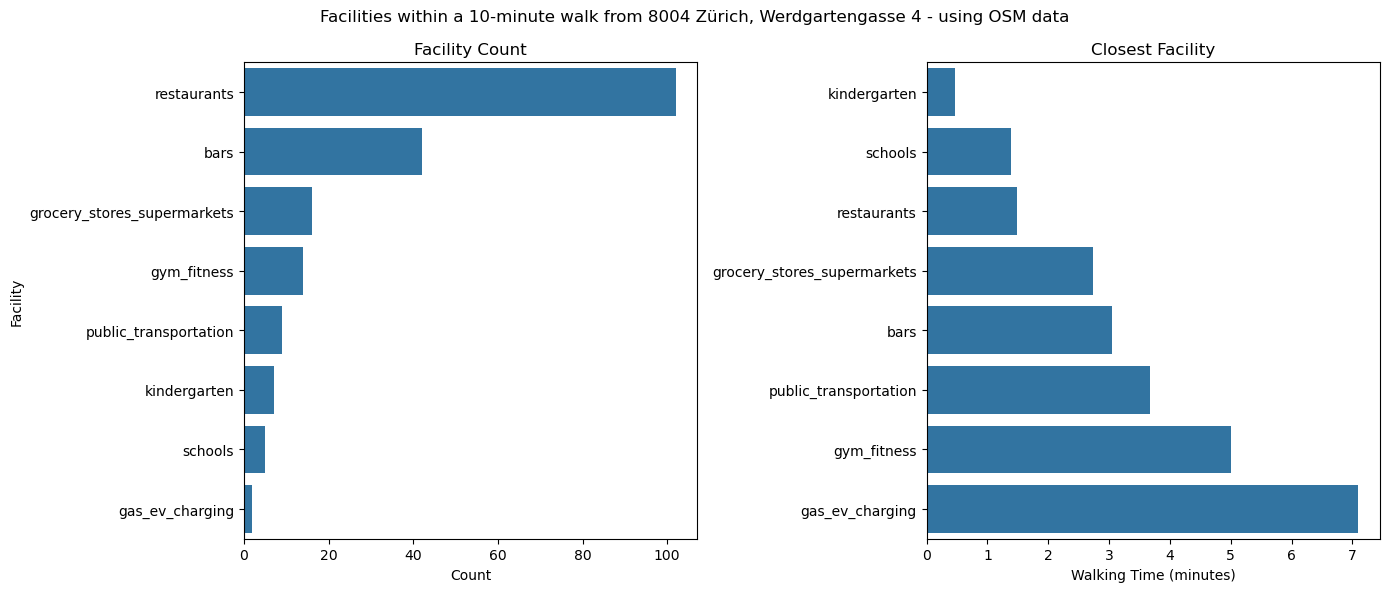

In [14]:
plot_data(data)

In [15]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 8004 Zürich, Werdgartengasse 4
Coordinates: (47.371131, 8.52655958674174)

----------------------------------------

Bars
--------------------
Bars count: 42
Closest bars: Penalty Restaurant Bar
Travel time to closest bars: 3.05 minutes

Place_id: 298172595
Name: Plaza Bar
Location: {'lat': 47.3741673, 'lng': 8.524726}
Tags: {'addr:city': 'Zürich', 'addr:housenumber': '109', 'addr:postcode': '8004', 'addr:street': 'Badenerstrasse', 'amenity': 'bar', 'check_date': '2024-06-19', 'level': '0', 'name': 'Plaza Bar', 'opening_hours': 'Tu-Fr 17:00+;Sa 18:00+;PH closed', 'website': 'https://www.plaza-zurich.ch/programm-bar', 'wheelchair': 'limited'}

Place_id: 310788830
Name: Sport
Location: {'lat': 47.3756046, 'lng': 8.5245573}
Tags: {'alt_name': 'Sportbar', 'amenity': 'pub', 'name': 'Sport', 'outdoor_seating': 'yes', 'website': 'https://www.sport-bar.ch/', 'wheelchair': 'no'}

Place_id: 313218499
Name: Elisaburg
Loca

In [16]:
time.sleep(30)

### Example 2

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32480978](https://en.comparis.ch/immobilien/marktplatz/details/show/32480978)

Address: 3027 Bern, Colombstrasse 39

In [17]:
%%time

address = "3027 Bern, Colombstrasse 39"
data = get_facilities_data(address)

CPU times: user 75.5 ms, sys: 16.5 ms, total: 92 ms
Wall time: 24 s


In [18]:
file_name = 'Ex2_3027_Bern_Colombstrasse_39.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [19]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,1,8.57,Stars and Stripes
restaurants,7,4.85,Piazza
kindergarten,1,7.65,Holenacker I
public_transportation,4,3.49,Gäbelbach
gym_fitness,1,5.72,WingTsun
grocery_stores_supermarkets,2,3.10,Rüedu
gas_ev_charging,4,6.50,No name available
schools,0,NaN,None


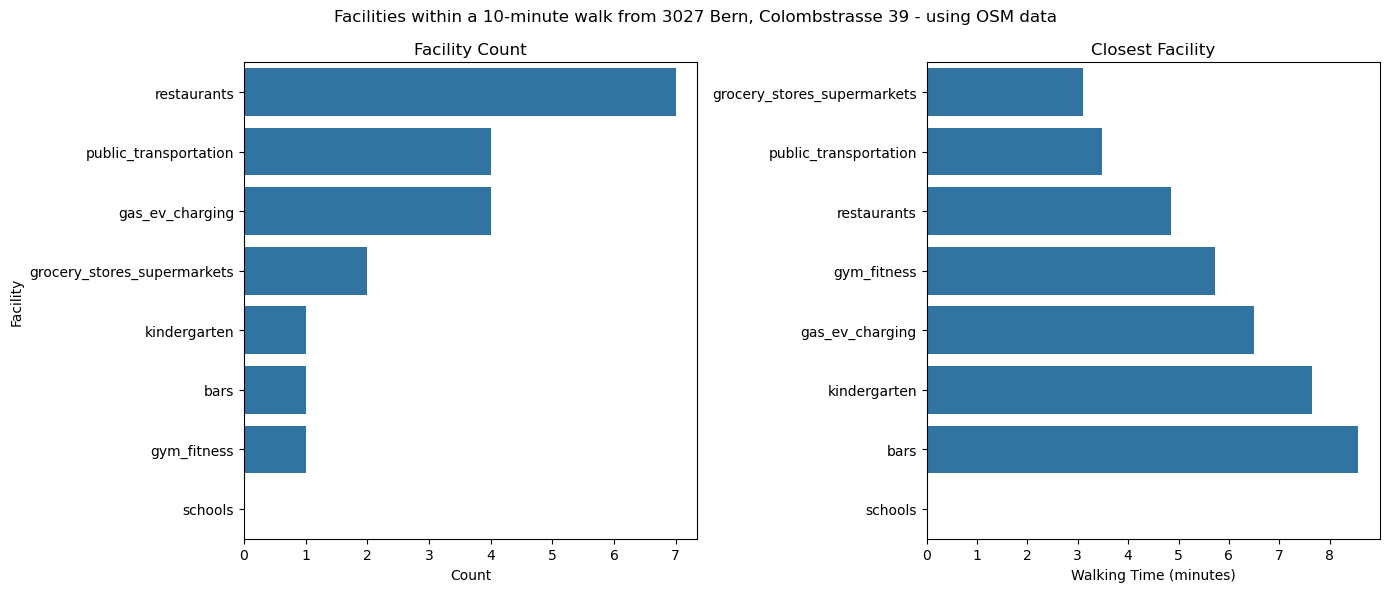

In [20]:
plot_data(data)

In [21]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 3027 Bern, Colombstrasse 39
Coordinates: (46.94559, 7.3777287)

----------------------------------------

Bars
--------------------
Bars count: 1
Closest bars: Stars and Stripes
Travel time to closest bars: 8.57 minutes

Place_id: 9482332061
Name: Stars and Stripes
Location: {'lat': 46.9441427, 'lng': 7.3724582}
Tags: {'amenity': 'bar', 'email': 'bern@starsandstripes.ch', 'level': '0', 'level:ref': '-1', 'name': 'Stars and Stripes', 'opening_hours': 'Mo-Th 17:00-22:00; Fr 17:00-23:30; Sa 15:00-23:30; Su 15:00-22:00', 'outdoor_seating': 'no', 'phone': '+41 31 991 25 25', 'website': 'https://www.starsandstripes.ch/de/p/standorte/bern-1109.html', 'wheelchair': 'yes'}




Restaurants
--------------------
Restaurants count: 7
Closest restaurants: Piazza
Travel time to closest restaurants: 4.85 minutes

Place_id: 2949154833
Name: Holi
Location: {'lat': 46.9493855, 'lng': 7.3804233}
Tags: {'addr:city': 'Bern', 'addr:c

In [22]:
time.sleep(30)

### Example 3

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32480354](https://en.comparis.ch/immobilien/marktplatz/details/show/32480354)

Address: 1006 Lausanne, Av. d'Ouchy 58

In [23]:
%%time

address = "1006 Lausanne, Av. d'Ouchy 58"
data = get_facilities_data(address)

CPU times: user 76.9 ms, sys: 20.1 ms, total: 97 ms
Wall time: 33.7 s


In [24]:
file_name = 'Ex3_1006_Lausanne_Av_d_Ouchy_58.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [25]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,2,3.26,MGM
restaurants,23,0.06,Takayama
kindergarten,0,NaN,None
public_transportation,1,3.39,Taxi Services - Ouchy
gym_fitness,0,NaN,None
grocery_stores_supermarkets,3,2.49,Kim Hoa alimentation asiatique
gas_ev_charging,1,8.93,Bateaux seulement
schools,1,6.85,Atelier céramique de la harpe - École de potterie


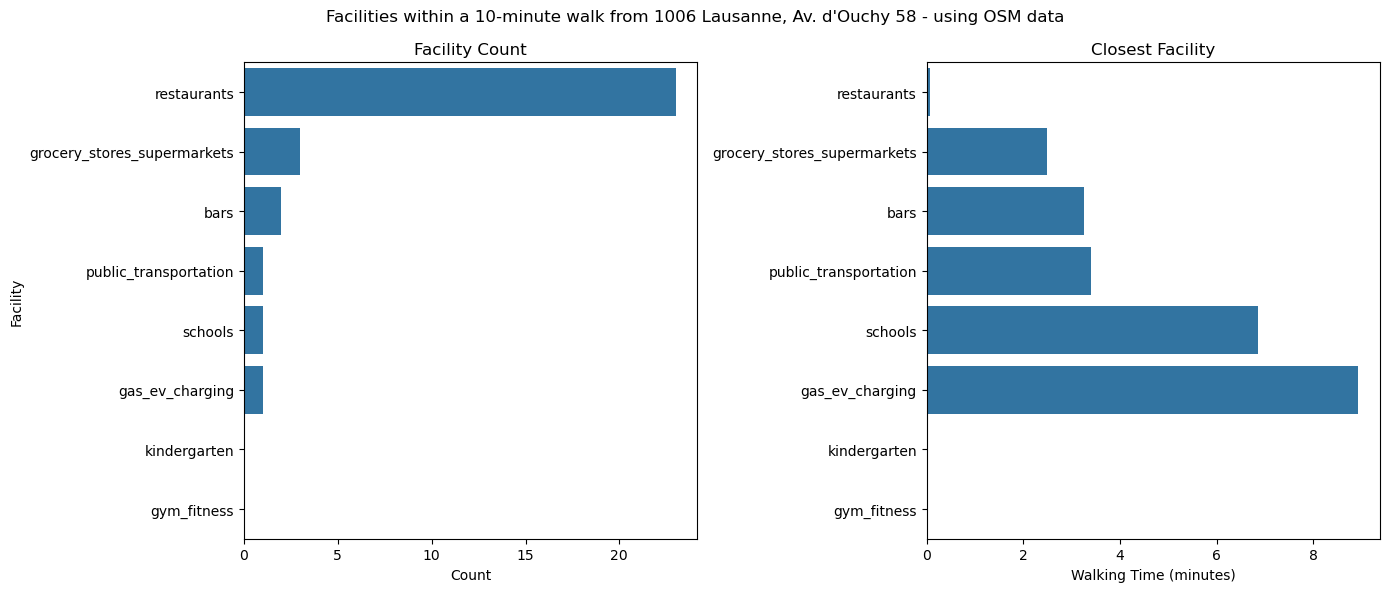

In [26]:
plot_data(data)

In [27]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 1006 Lausanne, Av. d'Ouchy 58
Coordinates: (46.508742299999994, 6.6273949499999985)

----------------------------------------

Bars
--------------------
Bars count: 2
Closest bars: MGM
Travel time to closest bars: 3.26 minutes

Place_id: 1244887747
Name: MGM
Location: {'lat': 46.507429, 'lng': 6.62574}
Tags: {'addr:housenumber': '14', 'addr:postcode': '1007', 'addr:street': 'Rue du Lac', 'amenity': 'pub', 'contact:facebook': 'cafemgmlausanne', 'email': 'info@mgmcafe.ch', 'name': 'MGM', 'opening_hours': 'Mo-Th 07:30-01:00; Fr 07:30-02:00; Sa 08:45-02:00; Su 09:00-01:00', 'opening_hours:signed': 'no', 'phone': '+41 21 616 38 81', 'website': 'https://www.lausanne-tourisme.ch/en/explore/mgm-cafe/'}

Place_id: 4861643846
Name: Florida
Location: {'lat': 46.5116148, 'lng': 6.6260278}
Tags: {'addr:postcode': '1007', 'amenity': 'pub', 'name': 'Florida', 'opening_hours': 'Mo-Fr 09:15-22:00; Sa 09:15-23:00', 'phone': '+41

In [28]:
time.sleep(30)

### Example 4

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32476087](https://en.comparis.ch/immobilien/marktplatz/details/show/32476087)

Address: 8355 Aadorf, Bruggwiesenstrasse 5

In [29]:
%%time

address = "8355 Aadorf, Bruggwiesenstrasse 5"
data = get_facilities_data(address)

CPU times: user 54.8 ms, sys: 12.8 ms, total: 67.6 ms
Wall time: 26.1 s


In [30]:
file_name = 'Ex4_8355_Aadorf_Bruggwiesenstrasse_5.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [31]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,1,4.39,Päng Pub
restaurants,3,2.93,El Capone
kindergarten,0,NaN,None
public_transportation,0,NaN,None
gym_fitness,0,NaN,None
grocery_stores_supermarkets,2,7.63,Coop Pronto
gas_ev_charging,2,6.79,Ruedi Rüssel
schools,0,NaN,None


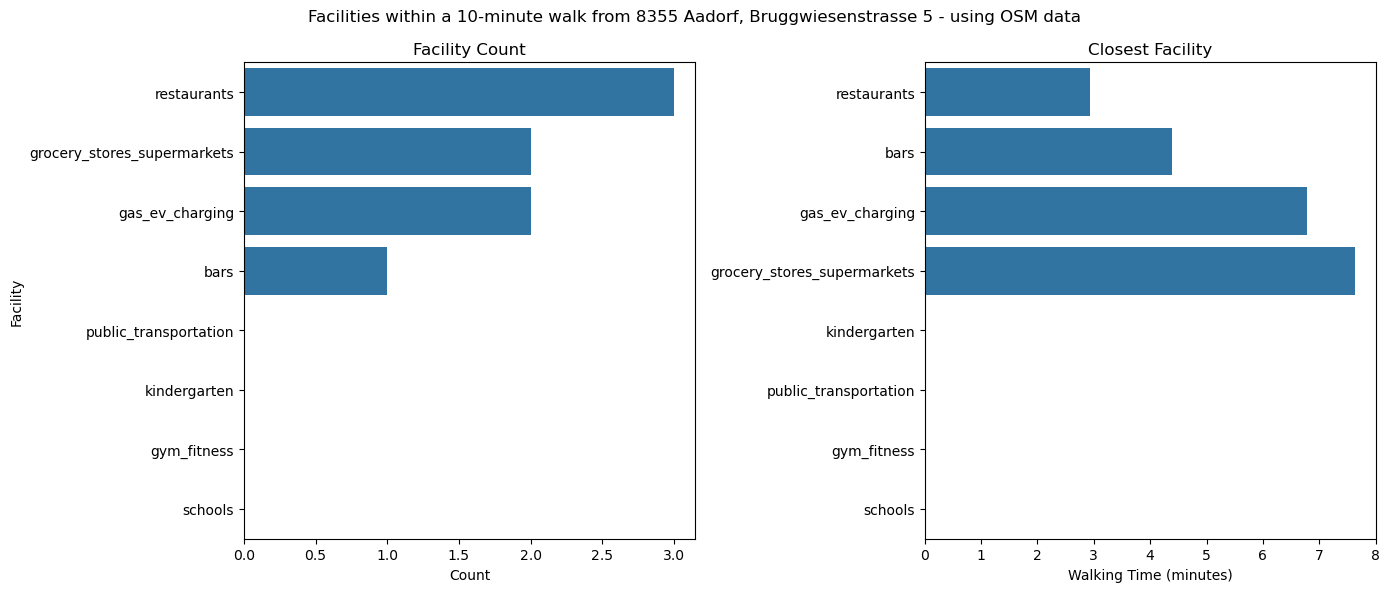

In [32]:
plot_data(data)

In [33]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 8355 Aadorf, Bruggwiesenstrasse 5
Coordinates: (47.492963450000005, 8.893470629289517)

----------------------------------------

Bars
--------------------
Bars count: 1
Closest bars: Päng Pub
Travel time to closest bars: 4.39 minutes

Place_id: 8073499923
Name: Päng Pub
Location: {'lat': 47.4930119, 'lng': 8.8947331}
Tags: {'amenity': 'pub', 'name': 'Päng Pub', 'opening_hours': 'Th-Sa 17:00-23:00', 'website': 'http://pängpub.ch/'}




Restaurants
--------------------
Restaurants count: 3
Closest restaurants: El Capone
Travel time to closest restaurants: 2.93 minutes

Place_id: 3468081765
Name: El Capone
Location: {'lat': 47.4939065, 'lng': 8.8941025}
Tags: {'amenity': 'restaurant', 'cuisine': 'pizza', 'name': 'El Capone', 'opening_hours': 'Tu-Sa 11:00-14:30,17:30-23:00; Su 11:00-14:30,17:30-22:00', 'url': 'http://www.elcapone.ch/'}

Place_id: 4002694690
Name: Bella Napoli
Location: {'lat': 47.4912407, 'lng': 8

In [34]:
time.sleep(30)

### Example 5

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32332137](https://en.comparis.ch/immobilien/marktplatz/details/show/32332137)

Address: 6319 Allenwinden, Winzrüti 39

In [12]:
%%time

address = "6319 Allenwinden, Winzrüti 39"
data = get_facilities_data(address)

CPU times: user 65.7 ms, sys: 17.1 ms, total: 82.8 ms
Wall time: 22.7 s


In [13]:
file_name = 'Ex5_6319_Allenwinden_Winzruti_39.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [14]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,0,NaN,None
restaurants,1,7.89,Löwen
kindergarten,0,NaN,None
public_transportation,0,NaN,None
gym_fitness,0,NaN,None
grocery_stores_supermarkets,0,NaN,None
gas_ev_charging,0,NaN,None
schools,0,NaN,None


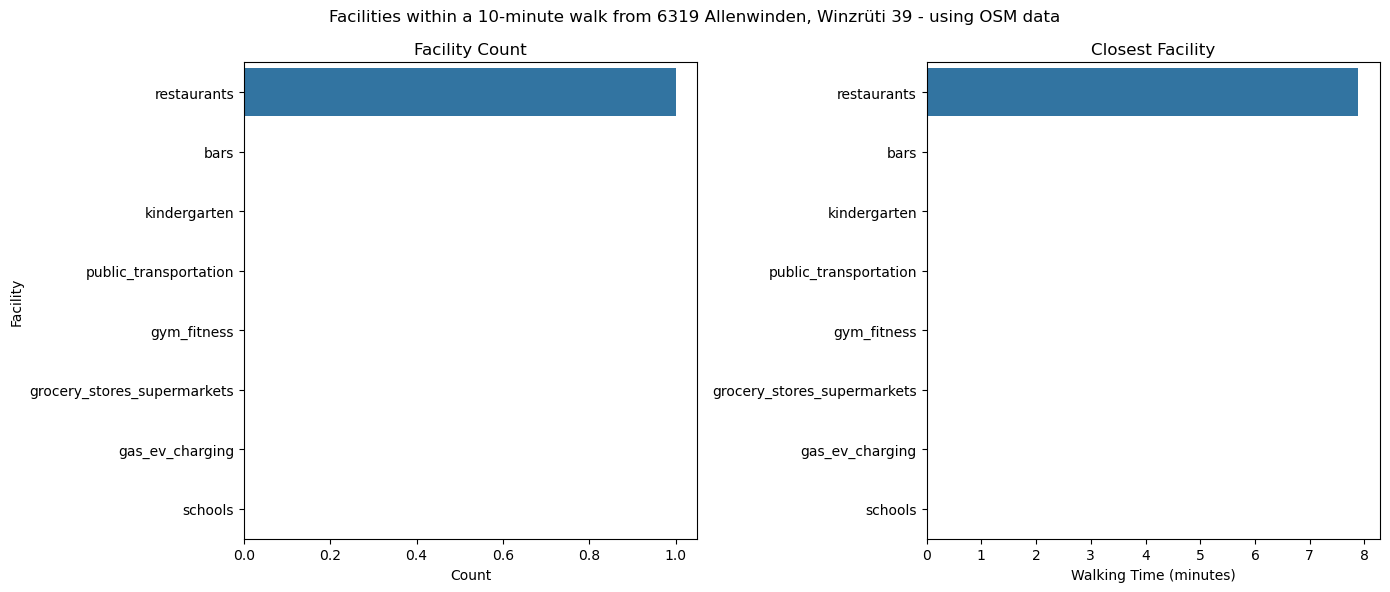

In [15]:
plot_data(data)

In [16]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 6319 Allenwinden, Winzrüti 39
Coordinates: (47.171187450000005, 8.55496775)

----------------------------------------

Bars
--------------------
Bars count: 0




Restaurants
--------------------
Restaurants count: 1
Closest restaurants: Löwen
Travel time to closest restaurants: 7.89 minutes

Place_id: 273500930
Name: Löwen
Location: {'lat': 47.1667167, 'lng': 8.5532237}
Tags: {'addr:city': 'Allenwinden', 'addr:housenumber': '35', 'addr:postcode': '6319', 'addr:street': 'Dorfstrasse', 'amenity': 'restaurant', 'name': 'Löwen', 'opening_hours:covid19': 'closed'}




Kindergarten
--------------------
Kindergarten count: 0




Public_transportation
--------------------
Public_transportation count: 0




Gym_fitness
--------------------
Gym_fitness count: 0




Grocery_stores_supermarkets
--------------------
Grocery_stores_supermarkets count: 0




Gas_ev_charging
--------------------
Gas_ev_charging count: 0




S

In [ ]:
time.sleep(30)

### Example 6

Constructor Academy, Zurich (previous office)

Address: 8005 Zürich, Heinrichstrasse 200

In [17]:
%%time

address = "8005 Zürich, Heinrichstrasse 200"
data = get_facilities_data(address)

CPU times: user 92.8 ms, sys: 18.2 ms, total: 111 ms
Wall time: 26.3 s


In [18]:
file_name = 'Ex6_8005_Zurich_Heinrichstrasse_200.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [19]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,25,0.70,Don Weber
restaurants,77,0.71,Don Weber
kindergarten,7,2.57,Kindertagesstätte Regenbogen
public_transportation,6,2.00,Löwenbräu
gym_fitness,7,2.24,yoga anker west
grocery_stores_supermarkets,12,3.51,Amuthan kiosk shop
gas_ev_charging,7,0.31,Besucher EBM
schools,6,2.05,Provisorium der Schule Kornhaus


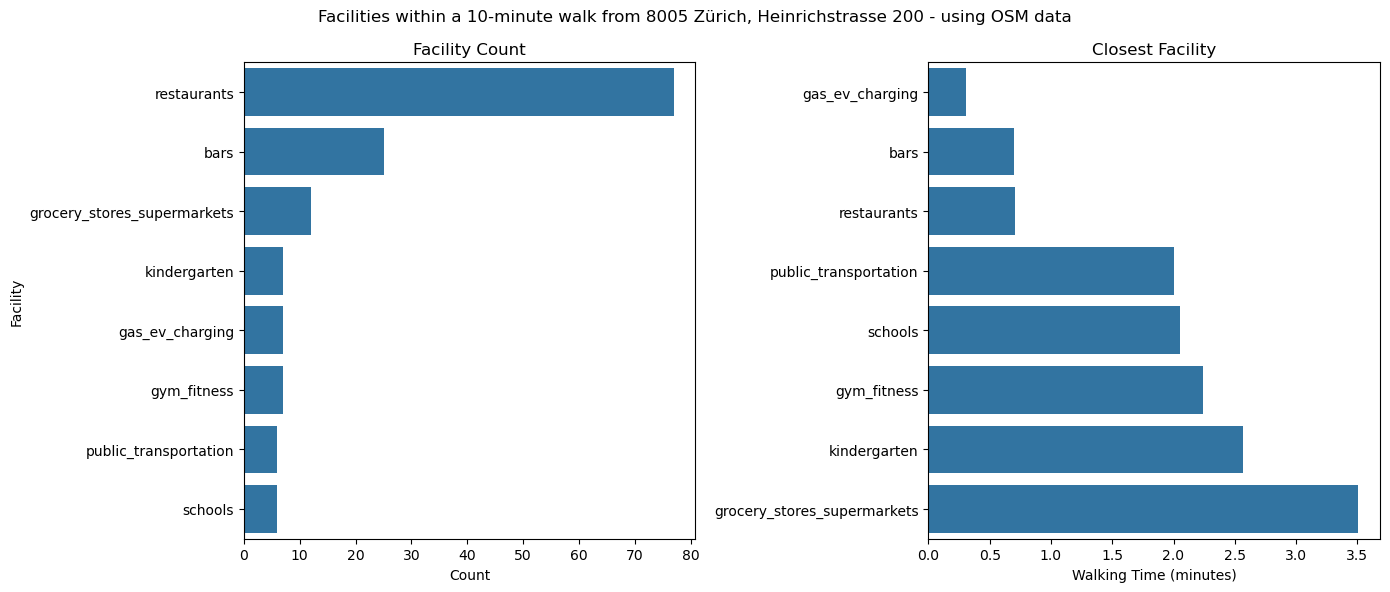

In [20]:
plot_data(data)

In [21]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 8005 Zürich, Heinrichstrasse 200
Coordinates: (47.3878165, 8.5251461)

----------------------------------------

Bars
--------------------
Bars count: 25
Closest bars: Don Weber
Travel time to closest bars: 0.7 minutes

Place_id: 267345323
Name: Big Ben Westside Pub
Location: {'lat': 47.3872345, 'lng': 8.519462}
Tags: {'addr:city': 'Zürich', 'addr:country': 'CH', 'addr:housenumber': '234', 'addr:postcode': '8005', 'addr:street': 'Hardstrasse', 'amenity': 'pub', 'check_date': '2024-06-04', 'name': 'Big Ben Westside Pub', 'opening_hours': 'Tu,We 17:00-24:00, Th 17:00-01:00, Fr 16:00-02:00, Sa 15:00-02:00, Mo 17:00-22:00, Mo-Fr 11:00-14:00', 'operator': 'Holenstein Gastro', 'outdoor_seating': 'yes', 'phone': '+41 44 271 02 66', 'website': 'https://www.bigbenwestside.ch/', 'wheelchair': 'no'}

Place_id: 267345815
Name: Billiardino
Location: {'lat': 47.388361, 'lng': 8.5223501}
Tags: {'addr:city': 'Zürich', 'addr:ho

In [ ]:
time.sleep(30)

## Example 7

Comparis Office, Zurich

Address: 8003 Zürich, Birmensdorferstrasse 108

In [22]:
%%time

address = "8003 Zürich, Birmensdorferstrasse 108"
data = get_facilities_data(address)

CPU times: user 94.4 ms, sys: 19.7 ms, total: 114 ms
Wall time: 41.4 s


In [23]:
file_name = 'Ex7_8003_Zurich_Birmensdorferstrasse_108.json'

with open(file_name, 'w') as file:
    json.dump(data, file, indent=4)

In [24]:
count_facilities(data)

,count,min_travel_time,closest_facility_name
bars,29,2.19,La Catedral
restaurants,111,0.66,Hikari
kindergarten,7,2.96,Aegerten 1 & 2
public_transportation,8,1.84,Bahnhof Wiedikon
gym_fitness,15,2.27,Budokan
grocery_stores_supermarkets,21,0.80,Lian Hua - Asia Laden
gas_ev_charging,2,4.39,BP Service Wiedikon
schools,4,2.07,isaJAZZDANCE im OFF DANCE


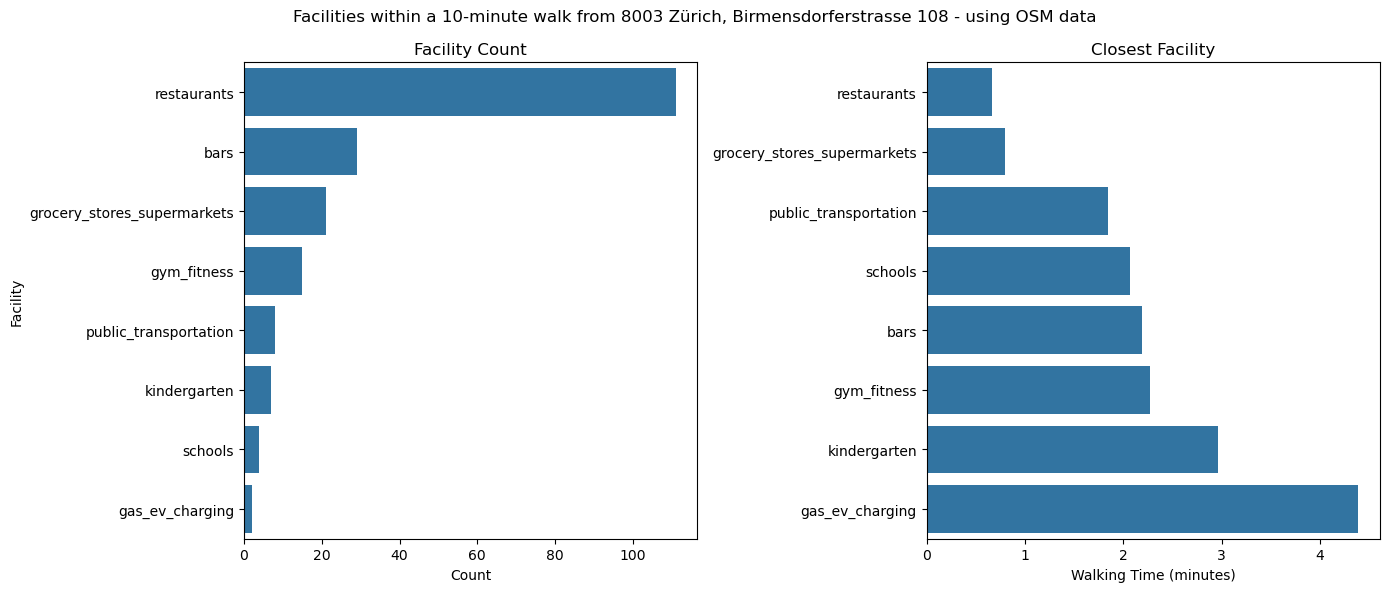

In [25]:
plot_data(data)

In [26]:
print_data(data)

Original Address Details:
----------------------------------------
Address: 8003 Zürich, Birmensdorferstrasse 108
Coordinates: (47.3706464, 8.52178327219605)

----------------------------------------

Bars
--------------------
Bars count: 29
Closest bars: La Catedral
Travel time to closest bars: 2.19 minutes

Place_id: 298172595
Name: Plaza Bar
Location: {'lat': 47.3741673, 'lng': 8.524726}
Tags: {'addr:city': 'Zürich', 'addr:housenumber': '109', 'addr:postcode': '8004', 'addr:street': 'Badenerstrasse', 'amenity': 'bar', 'check_date': '2024-06-19', 'level': '0', 'name': 'Plaza Bar', 'opening_hours': 'Tu-Fr 17:00+;Sa 18:00+;PH closed', 'website': 'https://www.plaza-zurich.ch/programm-bar', 'wheelchair': 'limited'}

Place_id: 310788830
Name: Sport
Location: {'lat': 47.3756046, 'lng': 8.5245573}
Tags: {'alt_name': 'Sportbar', 'amenity': 'pub', 'name': 'Sport', 'outdoor_seating': 'yes', 'website': 'https://www.sport-bar.ch/', 'wheelchair': 'no'}

Place_id: 313218499
Name: Elisaburg
Locatio

In [ ]:
time.sleep(30)